In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/CV projects/Road Sign Detection'

/content/drive/My Drive/CV projects/Road Sign Detection


# Import libraries

In [ ]:
import os

# Get dataset from Kaggle

In [ ]:
if not os.path.exists('annotations'):
  from google.colab import files
  files.upload()         # Upload file kaggle.json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d andrewmvd/road-sign-detection
  !unzip '/content/drive/My Drive/CV projects/Road Sign Detection/road-sign-detection.zip'
  !rm 'road-sign-detection.zip'
  !rm 'kaggle.json'

NameError: ignored

# Parse the file

In [ ]:
ANNOTATION_DIR = 'annotations'
IMAGES_DIR = 'images'

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

if not os.path.exists('data.csv'):
  rows = []
  columns= ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax', 'label']
  for xml_file in os.listdir(ANNOTATION_DIR):
    xml_path = f'{ANNOTATION_DIR}/{xml_file}'
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for obj in root.findall('object'):
      filename = root.find('filename').text
      width = int(root.find('size/width').text)
      height = int(root.find('size/height').text)
      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)
      label = obj.find('name').text

      rows.append({'filename': filename, 'width': width, 'height': height, 
                  'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax, 'label': label})
  data = pd.DataFrame(data=rows, columns= columns)
  data.to_csv('data.csv', index= False)

# Analyze data

In [ ]:
# Read resized data file 
data = pd.read_csv('data.csv')
data.head()

,filename,width,height,xmin,ymin,xmax,ymax,label
0,road1.png,400,283,154,63,258,281,trafficlight
1,road10.png,400,267,106,3,244,263,trafficlight
2,road0.png,267,400,98,62,208,232,trafficlight
3,road107.png,320,400,90,37,233,232,speedlimit
4,road112.png,400,267,137,12,272,152,speedlimit


In [ ]:
print(f"{len(data['filename'].unique())} images total")
print(f"{len(data)} bounding boxes total")

877 images total
1244 bounding boxes total


In [ ]:
LABELS = data['label'].unique()
LABELS

array(['trafficlight', 'speedlimit', 'stop', 'crosswalk'], dtype=object)

In [ ]:
NUM2LABEL = {}
LABEL2NUM = {}
for idx, label in enumerate(LABELS):
  NUM2LABEL[idx] = label
  LABEL2NUM[label] = idx
NUM2LABEL, LABEL2NUM

({0: 'trafficlight', 1: 'speedlimit', 2: 'stop', 3: 'crosswalk'},
 {'crosswalk': 3, 'speedlimit': 1, 'stop': 2, 'trafficlight': 0})

In [ ]:
# Add 'class' column to frame
data['class'] = data['label'].apply(lambda x: LABEL2NUM[x])
data.head()

,filename,width,height,xmin,ymin,xmax,ymax,label,class
0,road1.png,400,283,154,63,258,281,trafficlight,0
1,road10.png,400,267,106,3,244,263,trafficlight,0
2,road0.png,267,400,98,62,208,232,trafficlight,0
3,road107.png,320,400,90,37,233,232,speedlimit,1
4,road112.png,400,267,137,12,272,152,speedlimit,1


# Sample image

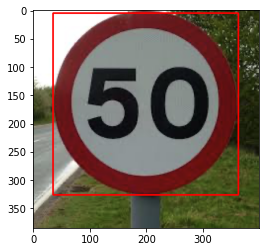

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def show_sample_image_bb(img_file, img_dir, df):
  img_path = f'{img_dir}/{img_file}'
  xmin = df[df['filename'] == img_file]['xmin'].values
  ymin = df[df['filename'] == img_file]['ymin'].values
  xmax = df[df['filename'] == img_file]['xmax'].values
  ymax = df[df['filename'] == img_file]['ymax'].values

  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  for i in range(len(xmin)):
    cv2.rectangle(img, (xmin[i], ymin[i]), (xmax[i], ymax[i]), (255,0,0), 2)
  plt.imshow(img)

# Show a sample image and its bounding boxes
IMG_FILE = os.listdir(IMAGES_DIR)[2]
show_sample_image_bb(IMG_FILE, IMAGES_DIR, data)

# Resize image

In [ ]:
IMAGE_SIZE = 256
RESIZED_IMAGES_DIR = 'resized images'


if not os.path.exists(RESIZED_IMAGES_DIR):
  os.mkdir(RESIZED_IMAGES_DIR)

  # Resize images 
  for RESIZED_IMG_FILE in os.listdir(IMAGES_DIR):
    IMG_PATH = f'{IMAGES_DIR}/{RESIZED_IMG_FILE}'
    img = cv2.imread(IMG_PATH)
    resized_img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    cv2.imwrite(f'{RESIZED_IMAGES_DIR}/{RESIZED_IMG_FILE}', resized_img)

def resized_bb(row, column):
  if column in ['xmin', 'xmax']:
    factor = row['width']/IMAGE_SIZE
  else:
    factor = row['height']/IMAGE_SIZE
  return int(row[column]/factor)

# Create new dataframe for resized images
if not os.path.exists('resized data.csv'):
  resized_data = data.copy()

  # Resize bouding boxes 
  for column in ['xmin', 'ymin', 'xmax', 'ymax']:
    resized_data[column] = resized_data.apply(lambda x: resized_bb(x, column), axis = 1)

  resized_data['height'] = IMAGE_SIZE
  resized_data['width'] = IMAGE_SIZE
  resized_data.to_csv('resized data.csv', index= False)

In [ ]:
# Read resized data file 
resized_data = pd.read_csv('resized data.csv')
resized_data.head()

,filename,width,height,xmin,ymin,xmax,ymax,label,class
0,road1.png,256,256,98,56,165,254,trafficlight,0
1,road10.png,256,256,67,2,156,252,trafficlight,0
2,road0.png,256,256,93,39,199,148,trafficlight,0
3,road107.png,256,256,72,23,186,148,speedlimit,1
4,road112.png,256,256,87,11,174,145,speedlimit,1


# Sample image

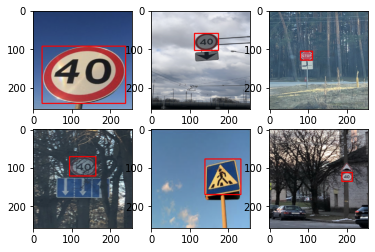

In [ ]:
# Show a sample resized image and its bounding boxes
import random
for i in range(6):
  plt.subplot(2, 3, i+1)
  idx = random.randint(0, 876)
  RESIZED_IMG_FILE = os.listdir(IMAGES_DIR)[idx]
  show_sample_image_bb(RESIZED_IMG_FILE, RESIZED_IMAGES_DIR, resized_data)

# Split train/val

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(resized_data, test_size= 0.2, random_state= 2020)

In [ ]:
print(f'{len(train_data)} train objects total')
print(f'{len(val_data)} val objects total')

995 train objects total
249 val objects total


# Custom dataset and Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
class RoadSignDataset(Dataset):
  def __init__(self, data_df, img_dir, transform= None):
    self.data_df = data_df
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, idx):
    img_file = self.data_df['filename'][idx]
    img_path = os.path.join(self.img_dir, img_file)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    xmin = self.data_df['xmin'][idx]
    ymin = self.data_df['ymin'][idx]
    xmax = self.data_df['xmax'][idx]
    ymax = self.data_df['ymax'][idx]
    bb = np.array([xmin, ymin, xmax, ymax], dtype= np.float32)
    cls = self.data_df['class'][idx]
    target = {'bb': bb, 'class': cls, 'img_path': img_path}
    if self.transform is not None:
      img, target = self.transform(img, target)

    return img,  target

In [ ]:
# Data augmentation
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
from torchvision import transforms
data_transform = transforms.Compose([#transforms.ToTensor(),
                                     transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

In [ ]:
train_ds = RoadSignDataset(data_df= train_data,
                                    img_dir= 'resized images',
                                    transform=None)
val_ds = RoadSignDataset(data_df= val_data,
                                    img_dir= 'resized images',
                                    transform=None)

In [ ]:
train_ds[0][2]

tensor(0)

(256, 256, 3)

dtype('uint8')

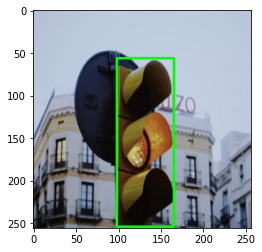

In [ ]:
xmin, ymin, xmax, ymax = train_ds[0][1].tolist()
xmin = int(xmin)
ymin = int(ymin)
xmax = int(xmax)
ymax = int(ymax)
img = train_ds[0][0]
cv2.rectangle(img, (xmin, ymin), (xmax,ymax), (0,255,0), 2)
plt.imshow(img)
type(train_ds[0][0])
train_ds[0][0].dtype

In [ ]:
# Dataloader
BATCH_SIZE = 64
train_dl = DataLoader(train_ds, batch_size= BATCH_SIZE, shuffle= True)
val_dl = DataLoader(val_ds, batch_size= BATCH_SIZE)

AttributeError: ignored